# Data Mining

## Lab X: Intro to Bayesian Statistics

In this module, you will learn how we can use PyMC3, a probabilistic programming library, to do Bayesian inference. We will go through some analytical and numerical analysis of some cases.

In [1]:
from IPython.display import display, HTML
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

%matplotlib inline

## Mandatory Coin Flip Example

You play a game with your friend Bob, in which you bet on the outcome of a coin flip. The coin has been provided by Bob. You think that there is a 50% chance that Bob would have provided an unfair coin. If the coin is unfair, you have no knowledge of the probability that the coin will turn up heads, so if asked, you would model the distribution over this probability as uniform. You flip the coin once, and it comes up heads. You flip the coin a second time, and it comes up heads again. What is the probability now that the coin is fair? Justify your answer.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [which_coin]
>NUTS: [theta_bias]
Sampling 4 chains: 100%|██████████| 30000/30000 [00:04<00:00, 7121.83draws/s]


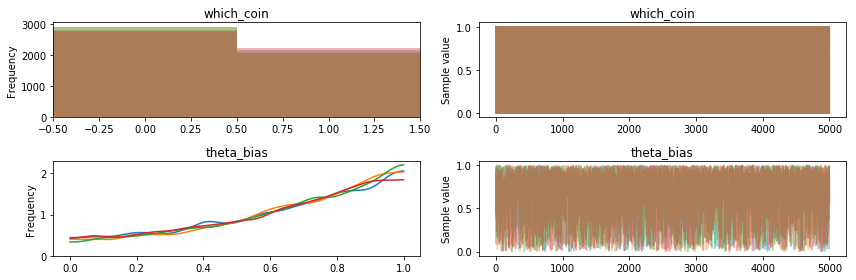

In [2]:
with pm.Model() as coinflip:
    which_coin = pm.Bernoulli('which_coin', 0.5)
    theta_biased = pm.Uniform('theta_biased', 0, 1)
    p = pm.math.switch(which_coin > 0.5, 0.5, theta_biased)
    heads = pm.Binomial('heads', n=2, p=p, observed=2)
    
    coin_trace = pm.sample(5000, tune=2500)

pm.traceplot(coin_trace);

In [33]:
display(HTML(
    '$p(coin=fair|\mathcal D)={}$'.format(coin_trace['which_coin'].mean())
))

### Analytical Solution

\begin{align}
coin \in \{fair, biased\} \\
coin \sim Bernoulli(0.5) \\
\theta|coin = \begin{cases}
0.5 & \text{ if } coin=fair \\ 
Unif(0,1) & \text{ if } coin=biased 
\end{cases} \\
X \sim Bernoulli(\theta)
\end{align}

Question: $p(coin = fair|X_1=H,X_2=H) =~...$

Using Bayes' rule
\begin{align}
p(coin = fair|X_1=H,X_2=H) &= \frac{p(X_1=H,X_2=H|coin=fair)p(coin=fair)}{p(X_1=H,X_2=H)} \\
&= \frac{p(HH|fair)p(fair)}{p(HH|fair)p(fair) + p(HH|biased)p(biased)} \\
\end{align}

We know that $p(HH|fair) = p(H|fair) \cdot p(H|fair)$. Thus,

\begin{align}
p(HH|fair) &= 0.5^2 = 0.25
\end{align}

while $p(coin=fair) = 0.5$ and $p(coin=biased) = 1 - 0.5 = 0.5$.

Since we don't know the exact value of $\theta|biased$, we should evaluate the expected value of getting two heads.

\begin{align}
p(HH|biased) &= E[HH|\theta] \\
&= \int_0^1 p(\theta) \cdot \theta \theta d\theta \\
&= \int_0^1 1 \cdot \theta^2 d\theta \\
&= \frac{\theta^3}{3} \Big|_0^1 = \frac{1}{3}
\end{align}

Hence,

\begin{align}
p(fair|HH) &= \frac{0.25 \cdot 0.5}{0.25 \cdot 0.5 + \frac{1}{3} \cdot 0.5} \\
&= 0.4286
\end{align}

## Effective Engineering

In [6]:
da_points_solved = [47,55,39,36,27,37,31,33,39,38,20,52,36,40,10,41,42,11,20,15,26,30,11,22,25,19,51,29,17,29,39,30,54,35]
da_points = [82,68,64,45,27,48,43,46,52,46,39,59,55,59,35,65,61,18,27,37,38,42,34,27,30,37,51,36,30,42,47,47,62,57]
dw_points_solved = [8,5,12,9,11,5,5,2,12,20,8,27,22,17,5,11,10,21,9,10,13,39,51,8,8,0,3,11,3,11,12,11,3]
dw_points = [13,23,15,21,11,5,5,7,12,20,8,27,40,32,15,11,15,37,22,10,25,67,64,18,20,20,8,11,11,11,23,22,14]
sw_points_solved = [8,11,6,6,12,12,7,15,13,6,17,12,3,11,6,7,6,9,10,0,0,6,17,16,19,9,15,10,14,8,24,17]
sw_points = [11,17,12,12,12,12,16,16,13,16,22,20,3,11,6,17,13,15,10,10,10,6,17,16,24,14,15,15,24,15,24,17]

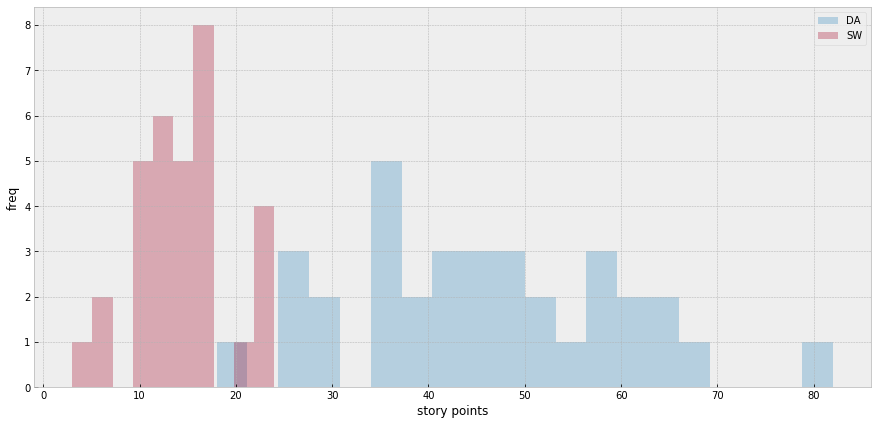

In [29]:
fig, ax = plt.subplots(figsize=(15,7))
plt.hist(da_points, bins=20, alpha=0.3, label='DA')
plt.hist(sw_points, bins=10, alpha=0.3, label='SW')
plt.xlabel('story points')
plt.ylabel('freq')
plt.legend();

In [31]:
import pymc3 as pm

with pm.Model() as model:
    p_sw = pm.Beta('completion_rate_sw', alpha=1, beta=1)
    solved_sw = pm.Binomial('solved_points_sw', n=sw_points, p=p_sw, observed=sw_points_solved)
    
    p_da = pm.Beta('completion_rate_da', alpha=1, beta=1)
    solved_da = pm.Binomial('solved_points_da', n=da_points, p=p_da, observed=da_points_solved)
    
    diff = pm.Deterministic('diff', p_sw - p_da)
    
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [completion_rate_da, completion_rate_sw]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4874.94draws/s]


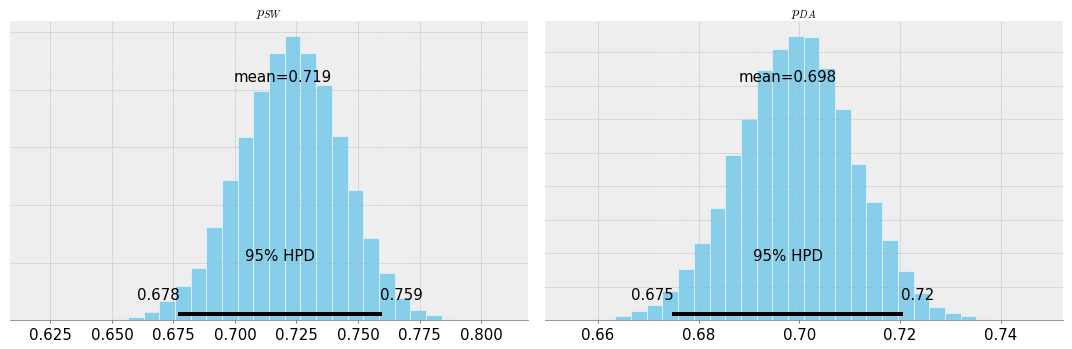

In [49]:
ax = pm.plot_posterior(trace, varnames=['completion_rate_sw', 'completion_rate_da'], figsize=(15,5))
ax[0].set_title('$p_{SW}$')
ax[1].set_title('$p_{DA}$');

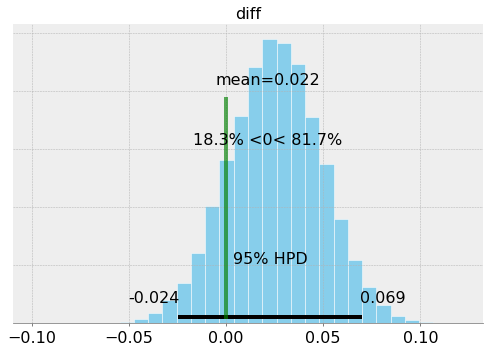

In [58]:
pm.plot_posterior(trace, varnames=['diff'], ref_val=0, text_size=16, figsize=(7,5));

In [34]:
display(HTML(
    '$P(p_{SW} > p_{DA}) = %.2f$' % ((trace['diff'] > 0).mean())
))

In [38]:
print('P(p_{SW} > p_{DA}) = %.2f' % ((trace['diff'] > 0).mean()))

P(p_{SW} > p_{DA}) = 0.82


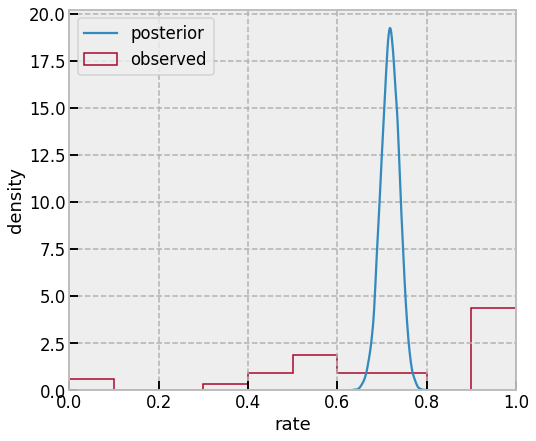

In [14]:
fig, ax = plt.subplots(figsize=(8,7))
sns.distplot(trace['completion_rate_sw'], hist=False, label='posterior')
plt.hist(np.array(sw_points_solved)/np.array(sw_points), histtype='step', density=True, label='observed')
plt.xlim([0,1])
plt.legend()
plt.xlabel('rate')
plt.ylabel('density');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_sw, alpha_sw]
100%|██████████| 1000/1000 [00:15<00:00, 64.64it/s]


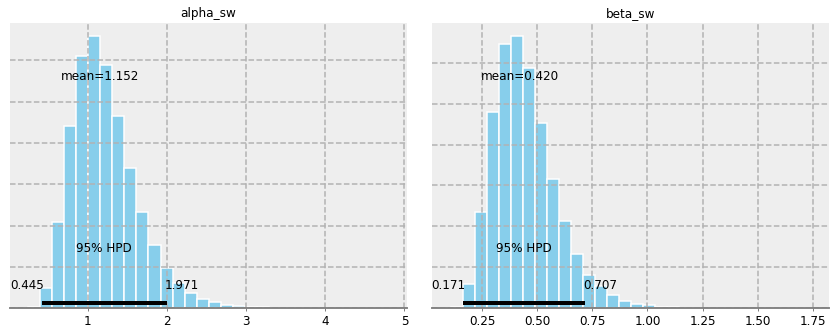

In [15]:
with pm.Model() as model:
    alpha_sw = pm.HalfCauchy('alpha_sw', beta = 2.)
    beta_sw = pm.HalfCauchy('beta_sw', beta = 2.)
    solved_sw = pm.BetaBinomial('solved_points_sw', alpha=alpha_sw, beta=beta_sw, n=sw_points, observed=sw_points_solved)
    
    tr = pm.sample(50000)
    
    p_sw = pm.Beta('p_sw', alpha=alpha_sw, beta=beta_sw)
    ppc = pm.sample_posterior_predictive(tr, 1000, vars=[p_sw])

pm.plot_posterior(tr, figsize=(12,5));

In [17]:
pm.summary(tr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_sw,1.152101,0.412026,0.001594,0.445380,1.970657,67951.753393,1.000016
beta_sw,0.419597,0.144456,0.000561,0.171348,0.706716,65392.563708,1.000038


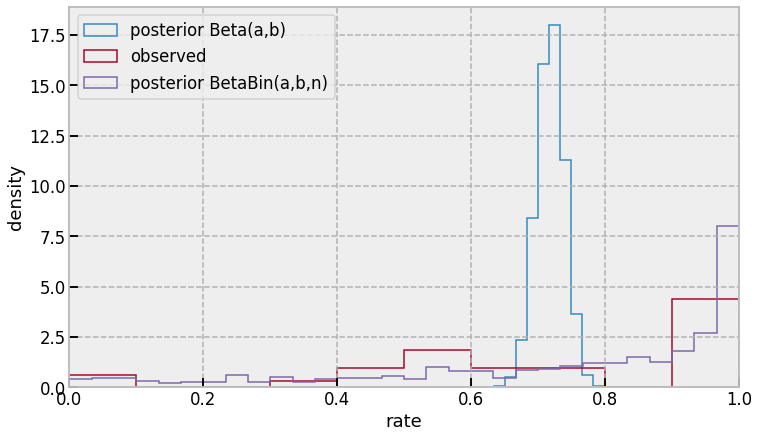

In [18]:
fig, ax = plt.subplots(figsize=(12,7))
plt.hist(trace['completion_rate_sw'], histtype='step', density=True, label='posterior Beta(a,b)')
plt.hist(np.array(sw_points_solved)/np.array(sw_points), histtype='step', density=True, label='observed')
plt.hist(ppc['p_sw'], histtype='step', density=True, bins=30, label='posterior BetaBin(a,b,n)')
plt.xlim([0,1])
plt.legend()
plt.xlabel('rate')
plt.ylabel('density');

## Bayesian M&M

[Original post](https://dataorigami.net/blogs/napkin-folding/29036419-bayesian-m-m-problem-in-pymc-2)

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [bag]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:03<00:00, 11465.75draws/s]


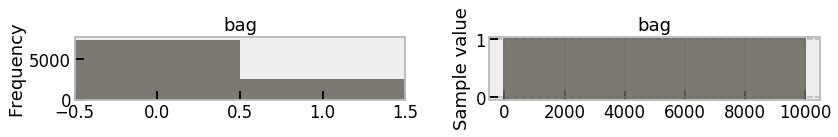

In [19]:
import theano.tensor as T
import theano

p = np.array([
    #brown, yellow, red, green, orange, tan, blue
    [.3,  .2,  .2,  .1, .1,  .1, .0 ], # 1994 bag
    [.13, .14, .13, .2, .16, .0, .24]  # 1996 bag
])

with pm.Model() as mm:
    bag = pm.Bernoulli('bag', .5)
    bag_prob = theano.shared(p)
    
    obs_1 = pm.Categorical('bag_1', bag_prob[bag], observed=1)
    obs_2 = pm.Categorical('bag_2', bag_prob[1-bag], observed=3)
    
    mm_trace = pm.sample(10000)

pm.traceplot(mm_trace);
display(HTML(
    '$p(bag=1994|\mathcal D)={}$'.format(1-mm_trace['bag'].mean())
))

### Analytical Solution

$$
mm94 \sim Categorical(.3,  .2,  .2,  .1, .1,  .1, .0) \\
mm96 \sim Categorical(.13, .14, .13, .2, .16, .0, .24) \\
bag \sim Bernoulli(.5) \\
bag \in \{1994, 1996\} \\
mm = \begin{cases}
mm94 & \text{ if } bag=1994 \\ 
mm96 & \text{ if } bag=1996
\end{cases}
$$

Question: $p(bag = 1994|mm_1 = 1, mm_2 = 3)$

*Note: Index starts from zero*

Using Bayes' rule
\begin{align}
p(bag = 1994|mm_1 = 1, mm_2 = 3) &= \frac{p(mm_1 = 1|bag=1994)p(bag=1994) \cdot p(mm_2 = 3|bag=1996)p(bag=1996)}{\sum_{bag} p(mm_1=1,mm_2=3|bag)} \\
&= \frac{.2 \times .5 \cdot .2 \times .5}{.2 \times .5 \cdot .2 \times .5 + .14 \times .5 \cdot .1 \times .5} \\
&= 0.74
\end{align}

## How many papers were submitted to BayesOpt16?

See this [original post](https://mfkasim91.github.io/2016/12/10/how-many-papers-were-submitted/).

In [41]:
with pm.Model() as bayesopt:
    s = pm.DiscreteUniform('s', lower=26, upper=100)
    eta = pm.Beta('eta', alpha=9, beta=3)
    a = pm.Binomial('a', n=s, p=eta, observed=[26])
    
    btrace = pm.sample(10000, tune=10000, init='map', random_seed=91)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [s]
>NUTS: [eta]
Sampling 4 chains: 100%|██████████| 80000/80000 [00:12<00:00, 6227.58draws/s]
The acceptance probability does not match the target. It is 0.9160084800743339, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.916869346093402, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


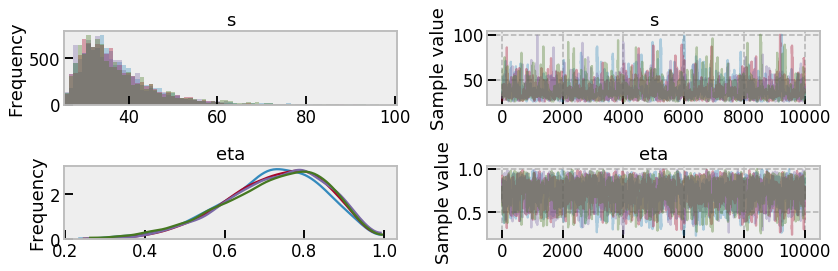

In [42]:
pm.traceplot(btrace);

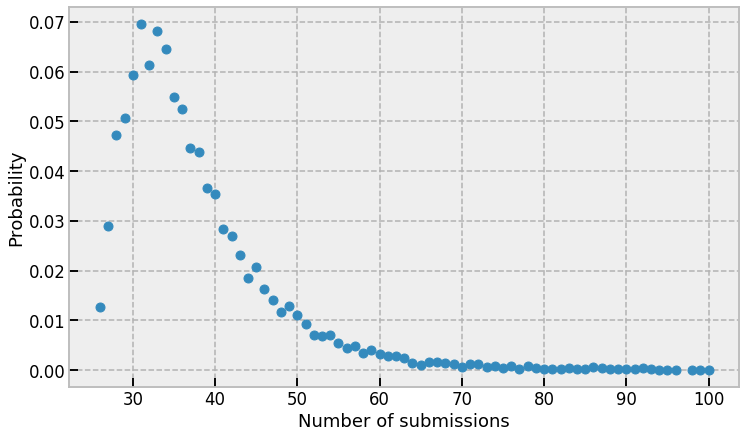

In [43]:
fig, ax = plt.subplots(figsize=(12,7))
pd.Series(btrace['s']).value_counts(True).sort_index().plot.line(marker='o', linestyle='')
plt.xlabel('Number of submissions')
plt.ylabel('Probability');
display(HTML(
    '$\hat{s}_{MAP} = %.0f$' % (pd.Series(btrace['s']).value_counts().index[0])
))
display(HTML(
    '$E[s] = %.2f \pm %.2f$' % (btrace['s'].mean(), btrace['s'].std())
))

### Analytical Solution

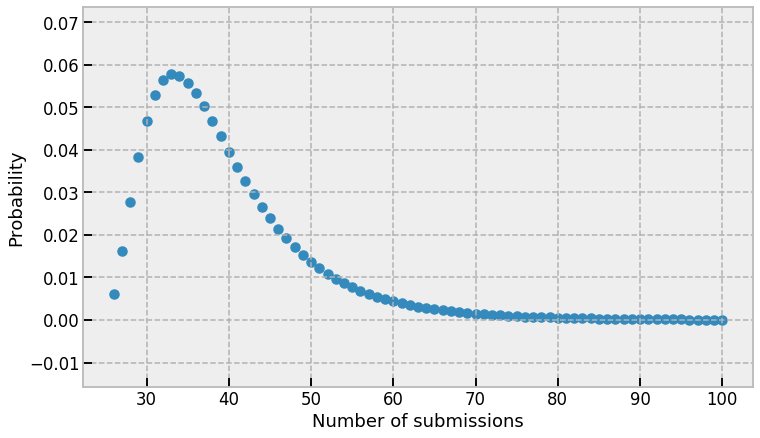

In [23]:
# Using the provided equation
from scipy.special import beta, binom

a = 26
r = 9
d = 12

def p(s, a, d, r):
    return binom(s, a) * beta(a + r + 1, s - a + d - r + 1)

pvec = np.vectorize(p)
energy = pvec(np.arange(a,101), a, d, r)
ps = energy/energy.sum()
fig, ax = plt.subplots(figsize=(12,7))
plt.scatter(np.arange(a,101), ps)
plt.xlabel('Number of submissions')
plt.ylabel('Probability');